Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Amazon Kindle_store
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [3]:
# importa dataset 'amazon kindle store'
data = pd.read_csv("../datasets/Kindle_Store.csv", names=['user_id', 'item_id', 'rating', 'timestamp'])
dataset_name = 'Amazon_Kindle_Store'
user_col = 'user_id'

In [4]:
data.shape

(5722988, 4)

In [5]:
data.head()

,user_id,item_id,rating,timestamp
0,1423600150,A27UD5HYAKBL97,4.0,1356739200
1,1423600150,A8P5DK8LLOYGH,5.0,1330992000
2,1423600150,A3OM9W7DXSUIIY,5.0,1250035200
3,1423600150,A3DPAR2PWB9BT8,3.0,1162512000
4,1423600150,A2ONTBSAX7GIOV,5.0,1144713600


### Keep only high ratings

<AxesSubplot:ylabel='Frequency'>

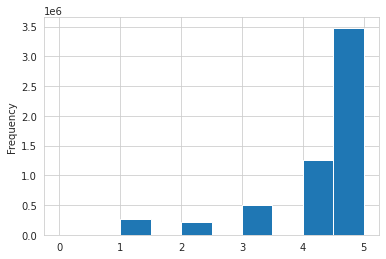

In [6]:
data['rating'].plot(kind='hist')

In [7]:
pos_ratings = np.quantile(data['rating'], q=0.8)

In [8]:
pos_ratings

5.0

In [9]:
data = data[ data['rating'] == pos_ratings ].drop(columns='rating')

In [10]:
# number of remaining cases
data.shape[0]

3479780

### Convert timestamp

In [11]:
%%time
data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date') # sort by date

CPU times: user 4.35 s, sys: 413 ms, total: 4.76 s
Wall time: 4.76 s


In [12]:
data.head()

,user_id,item_id,timestamp,date
3957826,B009DRL8LG,A1IBL0XQRJ200W,871603200,1997-08-15
92533,B0046A9VX2,A2KTTIY7HSLBFV,872208000,1997-08-22
3365139,B01D6NM4VA,A3IMAGCSRXL12Y,872208000,1997-08-22
3599648,B003YJEWLM,A1OFN8369L3EP2,872553600,1997-08-26
80659,B003R4ZOP2,A20UN1U2RQ0Y36,872640000,1997-08-27


In [13]:
data.tail()

,user_id,item_id,timestamp,date
5717958,B01HCB4LFE,A3S8GNGO2T7VEQ,1538352000,2018-10-01
5698088,B01GLZGGRI,AHXGHTNAI6VR8,1538352000,2018-10-01
5694162,B01GGCYJ16,A3L9TMJW3EJRJE,1538352000,2018-10-01
5716270,B01HAKH654,A2XP39MF3QAZV0,1538438400,2018-10-02
5711666,B01H45TR0M,A2N5017ICZCW2L,1538438400,2018-10-02


In [14]:
# keep year-month
data['date'] = data['date'].apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

## Evaluating Time defined Buckets 

Sampling the dataset

In [15]:
%%time
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: user 1.43 s, sys: 8.96 ms, total: 1.44 s
Wall time: 1.43 s


<AxesSubplot:xlabel='date'>

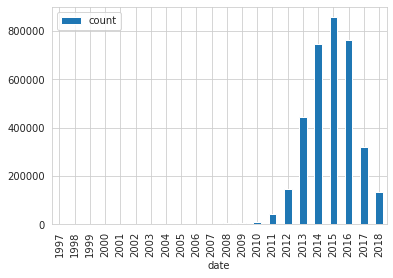

In [16]:
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.year
_.groupby('date').sum().plot(kind='bar')

In [17]:
y_filter = (data['date'] < datetime.strptime('2014-04', '%Y-%m')) & (datetime.strptime('2014', '%Y') <= data['date']) 
# y_filter = (data['date'] < datetime.strptime('2015', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 

In [18]:
data = data[y_filter]

In [19]:
# number of remaining cases
data.shape[0]

166612

Sampling the dataset - only most frequent users (overall)

In [20]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique()

CPU times: user 141 ms, sys: 111 µs, total: 142 ms
Wall time: 141 ms


<AxesSubplot:ylabel='Frequency'>

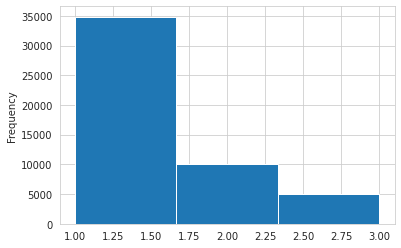

In [21]:
user_freq_over_months.plot(kind='hist',bins=user_freq_over_months.max())

In [22]:
# # we'll filter users with frequency higher than q
# threshold = np.quantile(user_freq_over_months, q=0.5)
# threshold

In [23]:
# # there are this many users with freq above the threshold
# (user_freq_over_months >= threshold).sum()

In [24]:
# # index of frequent users
# freq_users = user_freq_over_months[user_freq_over_months >= threshold].index

In [25]:
# # sample the dataset to contain only interactions from frequent users (that occur every month).
# # there is still a huge number of interactions - 1694351
# _ = data.set_index('user_id').loc[freq_users]
# _.shape
_ = data.set_index('user_id').copy()

<AxesSubplot:>

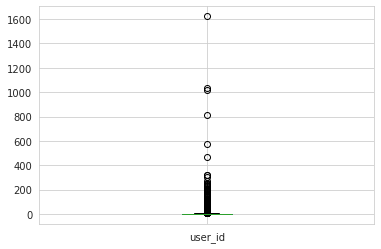

In [26]:
# frequency of users that occur every month:
_.reset_index()['user_id'].value_counts().plot(kind='box')

In [27]:
u = data['user_id'].value_counts().reset_index()['index'].to_list()

In [28]:
# to user, or not to use p ?
p = (data['user_id'].value_counts()/data['user_id'].shape[0])

In [29]:
prop = 0.2
s = round( len( u )*prop )

In [30]:
np.random.seed(42)
sampled_users = list( np.random.choice(u, size=s, replace=False, p=p) ) # , p=p

In [31]:
_.loc[sampled_users]

,item_id,timestamp,date
user_id,,,
B00540L9II,A8YTE1TF5277L,1389052800,2014-01-01
B00540L9II,A23UO5C3VLGA7Z,1389571200,2014-01-01
B00540L9II,APAMQMI5I3L05,1389830400,2014-01-01
B00540L9II,A3OP7WDIKONK0O,1390003200,2014-01-01
B00540L9II,A33IPI2VSA2HXC,1390089600,2014-01-01
...,...,...,...
B00EX6BDFS,A10W5M10DGKVYQ,1395100800,2014-03-01
B00H2ZK6FU,A3IRQCW03LJA0G,1389052800,2014-01-01
B00H2ZK6FU,A1F7ME5TYXFH8I,1392595200,2014-02-01


In [32]:
_.loc[sampled_users]['item_id'].nunique()

68944

<AxesSubplot:>

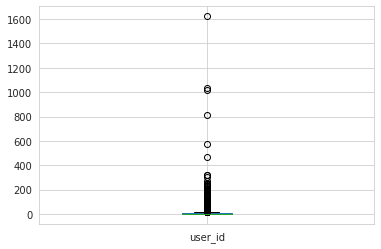

In [33]:
# frequency of users:
_.loc[sampled_users].reset_index()['user_id'].value_counts().plot(kind='box')

CPU times: user 166 ms, sys: 4.15 ms, total: 170 ms
Wall time: 167 ms


<AxesSubplot:ylabel='Frequency'>

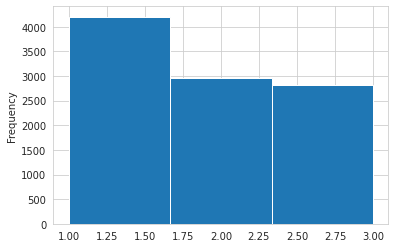

In [34]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months_sample = _.loc[sampled_users].reset_index().groupby(by=['user_id'])['date'].nunique()
user_freq_over_months_sample.plot(kind='hist',bins=user_freq_over_months_sample.max())

In [35]:
# np.quantile(_.reset_index()['user_id'].value_counts(), 0.9)

In [36]:
# # nu = int( _.reset_index()['user_id'].nunique()*0.0025 ) # 0.05% of users
# threshold = np.quantile(_.reset_index()['user_id'].value_counts(), 0.9) #_.reset_index()['user_id'].value_counts().iloc[:nu].min() # sample 5% of users with highest freq, this freq is the threshold
# freq_users = _.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ].index

In [37]:
# _.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ]

In [38]:
data['user_id'].nunique(), data['item_id'].nunique() # original number of users, original number of items

(49878, 117672)

In [39]:
# _.loc[freq_users].reset_index()['user_id'].nunique(), _.loc[freq_users].reset_index()['item_id'].nunique() # sample number of users, and of items
_.loc[sampled_users].reset_index()['user_id'].nunique(), _.loc[sampled_users].reset_index()['item_id'].nunique() # sample number of users, and of items

(9976, 68944)

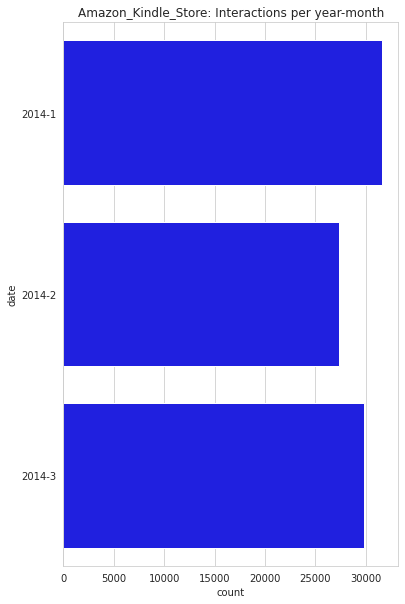

In [40]:
# %%time
# plot_interactions_per_month(data=_.loc[freq_users].reset_index(), dataset_name=dataset_name)
plot_interactions_per_month(data=_.loc[sampled_users].reset_index(), dataset_name=dataset_name)

In [41]:
# # sample again:
# # the frequency of the 5000th user with most interactions is used as threshold
# nu = int( _.reset_index()['user_id'].nunique()*0.05 ) # 5% of users
# threshold = _.reset_index()['user_id'].value_counts().iloc[:nu].min() # sample 10% of users with highest freq, this freq is the threshold
# freq_users = _.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ].index

In [42]:
# _.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ]

In [43]:
# data['user_id'].nunique(), data['item_id'].nunique() # original number of users, original number of items

In [44]:
# _.loc[freq_users].reset_index()['user_id'].nunique(), _.loc[freq_users].reset_index()['item_id'].nunique() # sample number of users, and of items

In [45]:
# previous (huge) sample
# data = data.set_index('user_id').loc[freq_users].reset_index()
# new sample - only 500 most frequent users, from users that occur in every month
# data = _.loc[freq_users].reset_index()
data = _.loc[sampled_users].reset_index()
data = data.sort_values(by='timestamp')

In [46]:
# number of remaining cases
data.shape[0]

88823

In [47]:
# sort by timestamp
# data = data.sort_values(by=['timestamp'])

In [48]:
# previous (huge) sample
# data.to_csv('output/amazonbooks_dump/sampled_amazon_books.csv', index=False)

# new sample
data.to_csv('output/amazonkindle_dump/2nd_sampled_amazon_kindle.csv', index=False)

How many interactions occur in each month / year?

In [49]:
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: user 175 ms, sys: 234 µs, total: 175 ms
Wall time: 174 ms


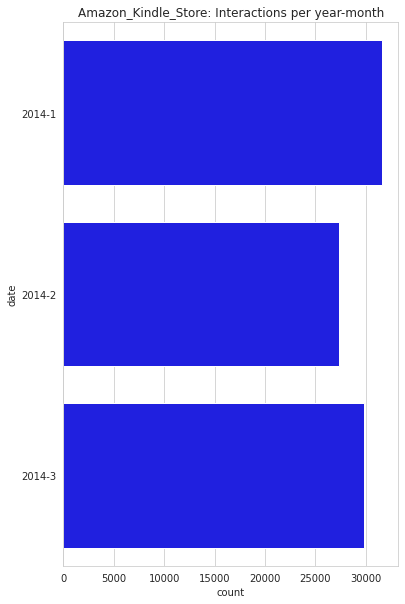

In [50]:
%%time
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [51]:
%%time
# 3min 16s
user_presence_df, user_month_interactions = get_interactions_info(data=data, user_col=user_col)

# new sample
user_presence_df.to_csv('output/amazonkindle_dump/2nd_sample_user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/amazonkindle_dump/2nd_sample_user_month_interactions.csv', index=False)

0.0 %
25.0 %
50.0 %
75.0 %
CPU times: user 56.7 s, sys: 35.1 ms, total: 56.8 s
Wall time: 56.8 s


In [52]:
user_presence_df.head()

,UserID,month_%
0,B00HCMAUIQ,1.0
1,B00FNH2MLA,1.0
2,B00FBTR6HK,1.0
3,B00HZUY35G,1.0
4,B001A06VJ8,1.0


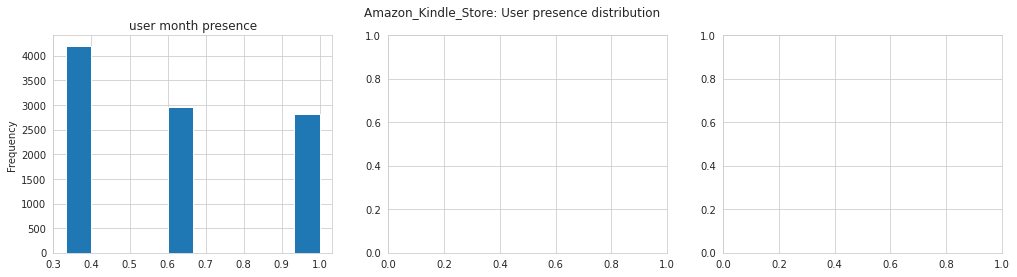

In [53]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

In [54]:
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

In [55]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [56]:
# defining threshold
frequency_threshold = 0.0

In [57]:
# frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)
frequent_users_month = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

9976 users of 9976 (100.0%) occurr in 0.0% or more months.


In [58]:
# old huge sample
# joblib.dump(frequent_users_month, 'output/amazonbooks_dump/frequent_users_month.joblib')

# new sample
joblib.dump(frequent_users_month, 'output/amazonkindle_dump/2nd_sample_frequent_users_month.joblib')

['output/amazonkindle_dump/2nd_sample_frequent_users_month.joblib']